# Previsão da Taxa de Desemprego no Brasil

Este projeto tem como objetivo analisar e modelar a série histórica da taxa de desemprego brasileira a partir dos dados da PNAD Contínua (IBGE), aplicando técnicas de séries temporais para gerar previsões fora da amostra.

In [ ]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuração visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
# Importa dados SIDRA
import requests
import pandas as pd

url = "https://apisidra.ibge.gov.br/values/t/6381/n1/all/v/4099/p/all"

response = requests.get(url)

data = response.json()

df = pd.DataFrame(data)

df.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Trimestre Móvel (Código),Trimestre Móvel
1,1,Brasil,2,%,8.0,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201203,jan-fev-mar 2012
2,1,Brasil,2,%,7.8,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201204,fev-mar-abr 2012
3,1,Brasil,2,%,7.7,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201205,mar-abr-mai 2012
4,1,Brasil,2,%,7.6,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201206,abr-mai-jun 2012


In [ ]:
df.columns = df.iloc[0]

# Tira a 1a linha (cabeçalho)
df = df[1:]

df.head()

,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Brasil (Código),Brasil,Variável (Código),Variável,Trimestre Móvel (Código),Trimestre Móvel
1,1,Brasil,2,%,8.0,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201203,jan-fev-mar 2012
2,1,Brasil,2,%,7.8,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201204,fev-mar-abr 2012
3,1,Brasil,2,%,7.7,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201205,mar-abr-mai 2012
4,1,Brasil,2,%,7.6,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201206,abr-mai-jun 2012
5,1,Brasil,2,%,7.5,1,Brasil,4099,"Taxa de desocupação, na semana de referência, ...",201207,mai-jun-jul 2012


In [ ]:
# nomes das colunas
df.columns

Index(['Nível Territorial (Código)', 'Nível Territorial',
       'Unidade de Medida (Código)', 'Unidade de Medida', 'Valor',
       'Brasil (Código)', 'Brasil', 'Variável (Código)', 'Variável',
       'Trimestre Móvel (Código)', 'Trimestre Móvel'],
      dtype='str', name=0)

In [ ]:
# Seleciona período e valor
df_clean = df[["Trimestre Móvel", "Valor"]].copy()

# Renomeia colunas
df_clean.columns = ["trimestre", "taxa_desemprego"]

# Converte taxa p/ número
df_clean["taxa_desemprego"] = (
    df_clean["taxa_desemprego"]
    .str.replace(",", ".")
    .astype(float)
)

df_clean.head()

,trimestre,taxa_desemprego
1,jan-fev-mar 2012,8.0
2,fev-mar-abr 2012,7.8
3,mar-abr-mai 2012,7.7
4,abr-mai-jun 2012,7.6
5,mai-jun-jul 2012,7.5


In [ ]:
# Dicionário p/ converter meses
mapa_meses = {
    "jan": "01", "fev": "02", "mar": "03",
    "abr": "04", "mai": "05", "jun": "06",
    "jul": "07", "ago": "08", "set": "09",
    "out": "10", "nov": "11", "dez": "12"
}

def extrair_data(trimestre_str):
    partes = trimestre_str.split()
    ano = partes[1]
    
    meses = partes[0].split("-")
    ultimo_mes = meses[-1]
    
    mes_num = mapa_meses[ultimo_mes]
    
    return f"{ano}-{mes_num}-01"

# Cria nova coluna de data
df_clean["data"] = df_clean["trimestre"].apply(extrair_data)

# Converte para datetime
df_clean["data"] = pd.to_datetime(df_clean["data"])

df_clean.head()

,trimestre,taxa_desemprego,data
1,jan-fev-mar 2012,8.0,2012-03-01
2,fev-mar-abr 2012,7.8,2012-04-01
3,mar-abr-mai 2012,7.7,2012-05-01
4,abr-mai-jun 2012,7.6,2012-06-01
5,mai-jun-jul 2012,7.5,2012-07-01


In [ ]:
# Ordena por data
df_clean = df_clean.sort_values("data")

# Define data como índice
df_clean = df_clean.set_index("data")

# Mantem so a coluna da taxa
serie = df_clean["taxa_desemprego"]

serie.head()

data
2012-03-01    8.0
2012-04-01    7.8
2012-05-01    7.7
2012-06-01    7.6
2012-07-01    7.5
Name: taxa_desemprego, dtype: float64

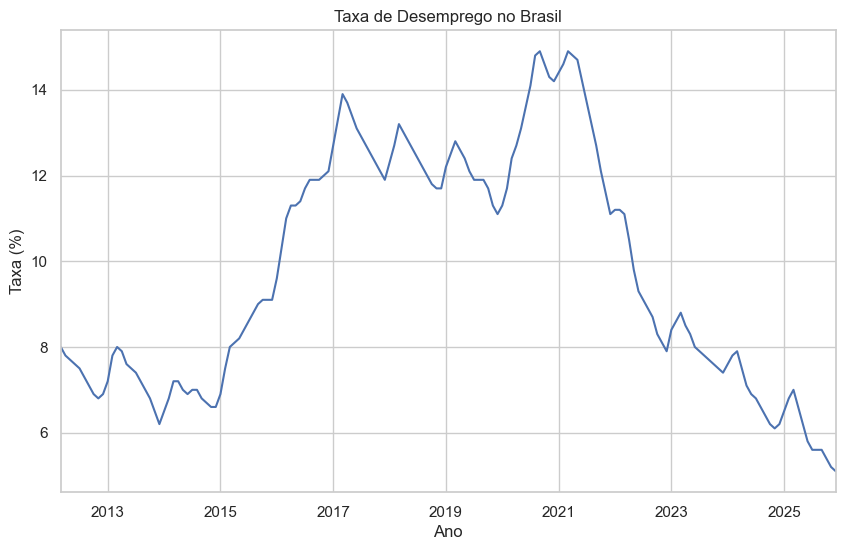

In [10]:
plt.figure()
serie.plot()
plt.title("Taxa de Desemprego no Brasil")
plt.ylabel("Taxa (%)")
plt.xlabel("Ano")
plt.show()

In [ ]:
# Teste de estacionariedade (ADF)
resultado_adf = adfuller(serie)

print("Estatística ADF:", resultado_adf[0])
print("p-valor:", resultado_adf[1])
print("Valores críticos:")
for chave, valor in resultado_adf[4].items():
    print(f"{chave}: {valor}")

Estatística ADF: -1.2542658316053374
p-valor: 0.6498275920011132
Valores críticos:
1%: -3.474120870218417
5%: -2.880749791423677
10%: -2.5770126333102494


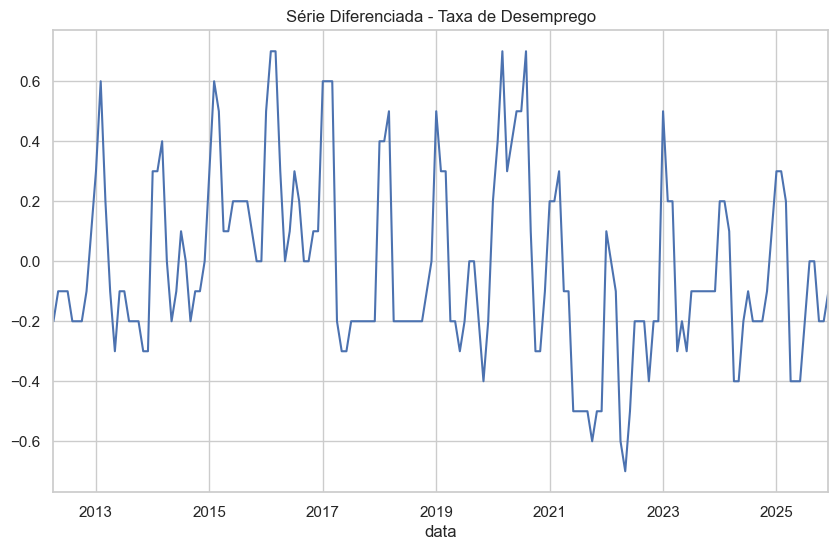

In [ ]:
# Diferenciação da série
serie_diff = serie.diff().dropna()

plt.figure()
serie_diff.plot()
plt.title("Série Diferenciada - Taxa de Desemprego")
plt.show()

In [ ]:
# Teste ADF
resultado_adf_diff = adfuller(serie_diff)

print("Estatística ADF:", resultado_adf_diff[0])
print("p-valor:", resultado_adf_diff[1])

Estatística ADF: -2.5827414877537462
p-valor: 0.09661697102897032


In [ ]:
# Aplicando 2a diferenciação
serie_diff2 = serie.diff().diff().dropna()

# Teste ADF na série c/ 2a diferença
resultado_adf_diff2 = adfuller(serie_diff2)

print("Estatística ADF:", resultado_adf_diff2[0])
print("p-valor:", resultado_adf_diff2[1])

Estatística ADF: -4.0761612234110975
p-valor: 0.001060229388112175


In [15]:
# Separo últimos 8 períodos para teste
train = serie.iloc[:-8]
test = serie.iloc[-8:]

print("Tamanho treino:", len(train))
print("Tamanho teste:", len(test))

Tamanho treino: 158
Tamanho teste: 8


In [16]:
# Ajustando modelo ARIMA(1,1,1)

modelo = ARIMA(train, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary())

c:\Users\Beatriz\Desktop\projecao-desemprego-br\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Beatriz\Desktop\projecao-desemprego-br\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Beatriz\Desktop\projecao-desemprego-br\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        taxa_desemprego   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  17.830
Date:                Thu, 26 Feb 2026   AIC                            -29.660
Time:                        20:08:12   BIC                            -20.491
Sample:                    03-01-2012   HQIC                           -25.936
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6000      0.097      6.212      0.000       0.411       0.789
ma.L1          0.1983      0.143      1.388      0.165      -0.082       0.478
sigma2         0.0464      0.005      9.893      0.0

In [17]:
# Gera previsão para o período de teste
forecast = resultado.forecast(steps=8)

# Visualiza previsões
forecast

2025-05-01    6.256695
2025-06-01    6.050695
2025-07-01    5.927085
2025-08-01    5.852913
2025-09-01    5.808407
2025-10-01    5.781700
2025-11-01    5.765675
2025-12-01    5.756060
Freq: MS, Name: predicted_mean, dtype: float64

In [18]:
# Cálculo das métricas
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.33740369973881
RMSE: 0.3834943293325597


In [19]:
# Modelo ingenuo: repete último valor do treino
naive_forecast = np.repeat(train.iloc[-1], 8)

# Métricas do modelo ingênuo
mae_naive = mean_absolute_error(test, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test, naive_forecast))

print("MAE naive:", mae_naive)
print("RMSE naive:", rmse_naive)

MAE naive: 1.0374999999999996
RMSE naive: 1.0868532559642077


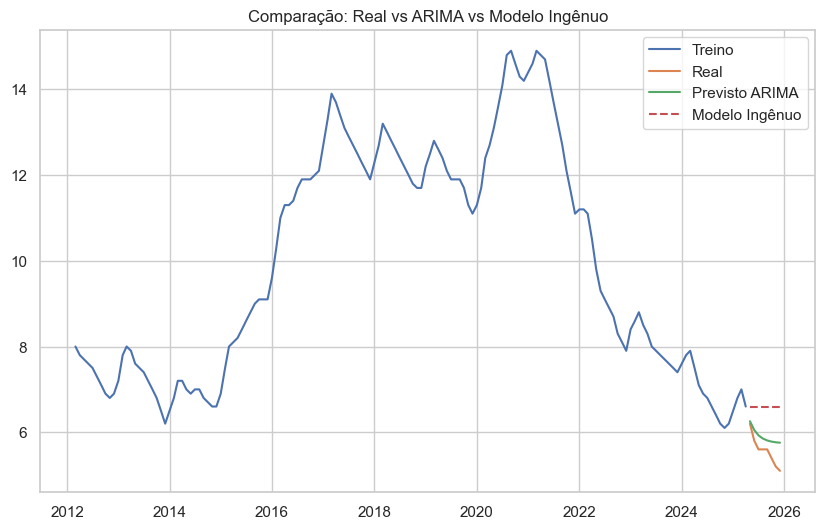

In [20]:
plt.figure()

plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Real")
plt.plot(test.index, forecast, label="Previsto ARIMA")
plt.plot(test.index, naive_forecast, label="Modelo Ingênuo", linestyle="--")

plt.title("Comparação: Real vs ARIMA vs Modelo Ingênuo")
plt.legend()
plt.show()

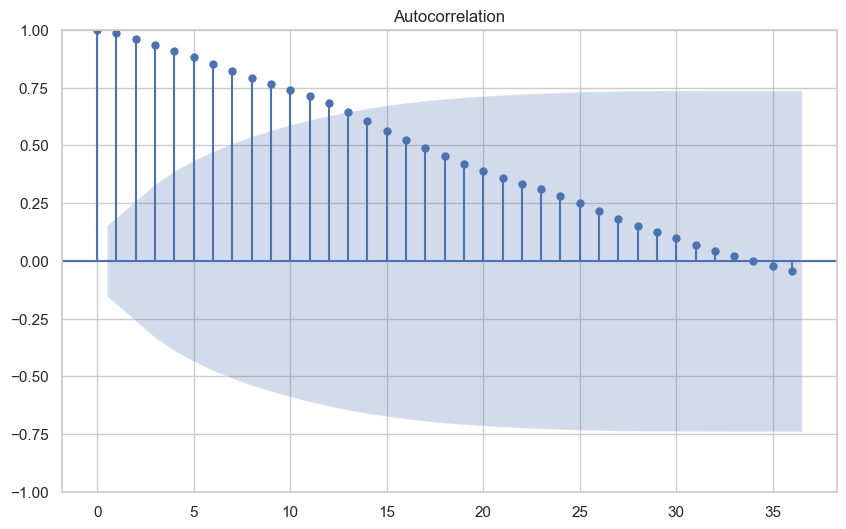

In [21]:
# Analise de autocorrelação (ACF)
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(serie, lags=36)
plt.show()

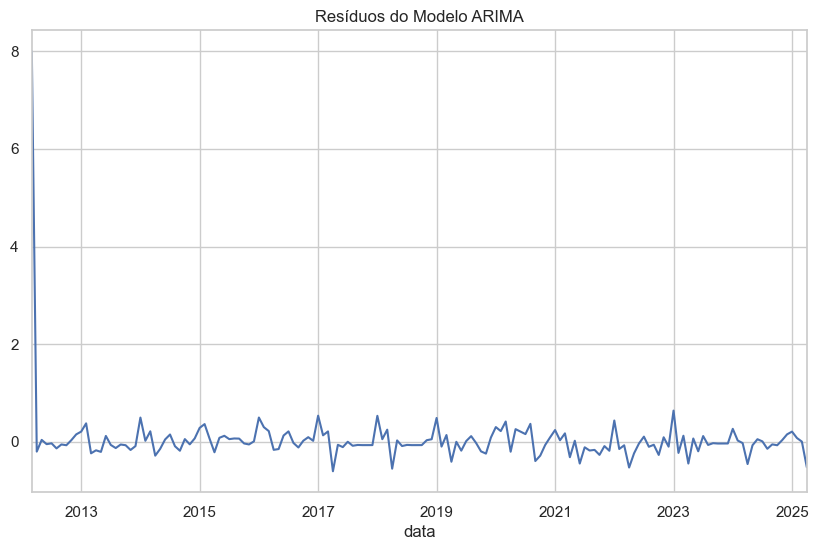

In [22]:
# diagnóstico dos resíduos
residuos = resultado.resid

plt.figure()
residuos.plot()
plt.title("Resíduos do Modelo ARIMA")
plt.show()

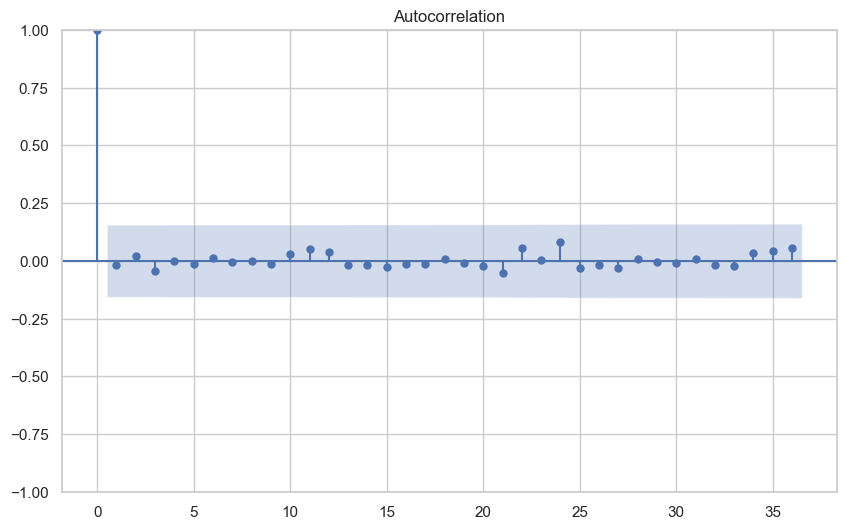

In [23]:
plot_acf(residuos, lags=36)
plt.show()

Conclusões

Este estudo analisou a série histórica da taxa de desemprego brasileira utilizando dados da PNAD Contínua (IBGE).

A série apresentou não estacionariedade, confirmada pelo teste ADF (p-valor > 0.05). Após aplicação de diferenciação de primeira ordem, a estacionariedade foi parcialmente atingida, sendo plenamente confirmada após segunda diferenciação.

Optou-se pela especificação ARIMA(1,1,1), considerando:

Interpretação econômica da série

Parcimônia do modelo

Diagnóstico adequado dos resíduos

O modelo apresentou:

MAE ≈ 0.34 p.p.

Desempenho superior ao modelo ingênuo (MAE ≈ 1.04 p.p.)

Resíduos com comportamento compatível com ruído branco

Conclui-se que o modelo captura adequadamente a dinâmica temporal da taxa de desemprego e produz previsões significativamente melhores que abordagens ingênuas.